In [1]:
import sys
import glob
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import matplotlib.pyplot as plt
from clisops.core.subset import subset_shape
import cartopy.crs as ccrs
import numpy as np
import geopandas as gp

sys.path.append('/g/data/xv83/quantile-mapping/qqscale')
import utils

Matplotlib is building the font cache; this may take a moment.


In [3]:
shape = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/australia/australia.shp')

xmin = 112.92
xmax = 153.63
ymin = -43.625
ymax = -10.07 

## Quantile adjustment factors

In [2]:
af_files = sorted(glob.glob("/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/*/ssp370/*/day/pr/2070-2099/pr-qdc-multiplicative-monthly-q100-adjustment-factors_*_ssp370_*_gn_2070-2099_wrt_1985-2014.nc"))
af_files

['/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/ACCESS-CM2/ssp370/r4i1p1f1/day/pr/2070-2099/pr-qdc-multiplicative-monthly-q100-adjustment-factors_ACCESS-CM2_ssp370_r4i1p1f1_gn_2070-2099_wrt_1985-2014.nc',
 '/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/ACCESS-ESM1-5/ssp370/r6i1p1f1/day/pr/2070-2099/pr-qdc-multiplicative-monthly-q100-adjustment-factors_ACCESS-ESM1-5_ssp370_r6i1p1f1_gn_2070-2099_wrt_1985-2014.nc',
 '/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/CESM2/ssp370/r11i1p1f1/day/pr/2070-2099/pr-qdc-multiplicative-monthly-q100-adjustment-factors_CESM2_ssp370_r11i1p1f1_gn_2070-2099_wrt_1985-2014.nc',
 '/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/CMCC-ESM2/ssp370/r1i1p1f1/day/pr/2070-2099/pr-qdc-multiplicative-monthly-q100-adjustment-factors_CMCC-ESM2_ssp370_r1i1p1f1_gn_2070-2099_wrt_1985-2014.nc',
 '/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/CNRM-E

In [4]:
max_af_dict = {}
for af_file in af_files:
    model = af_file.split('/')[8]
    ds = xr.open_dataset(af_file)
    max_af = ds['af'].max(dim=['month', 'quantiles'])
    max_af = subset_shape(max_af, shape=shape)
    max_af_dict[model] = max_af.compute()

In [5]:
model_list = list(max_af_dict.keys())

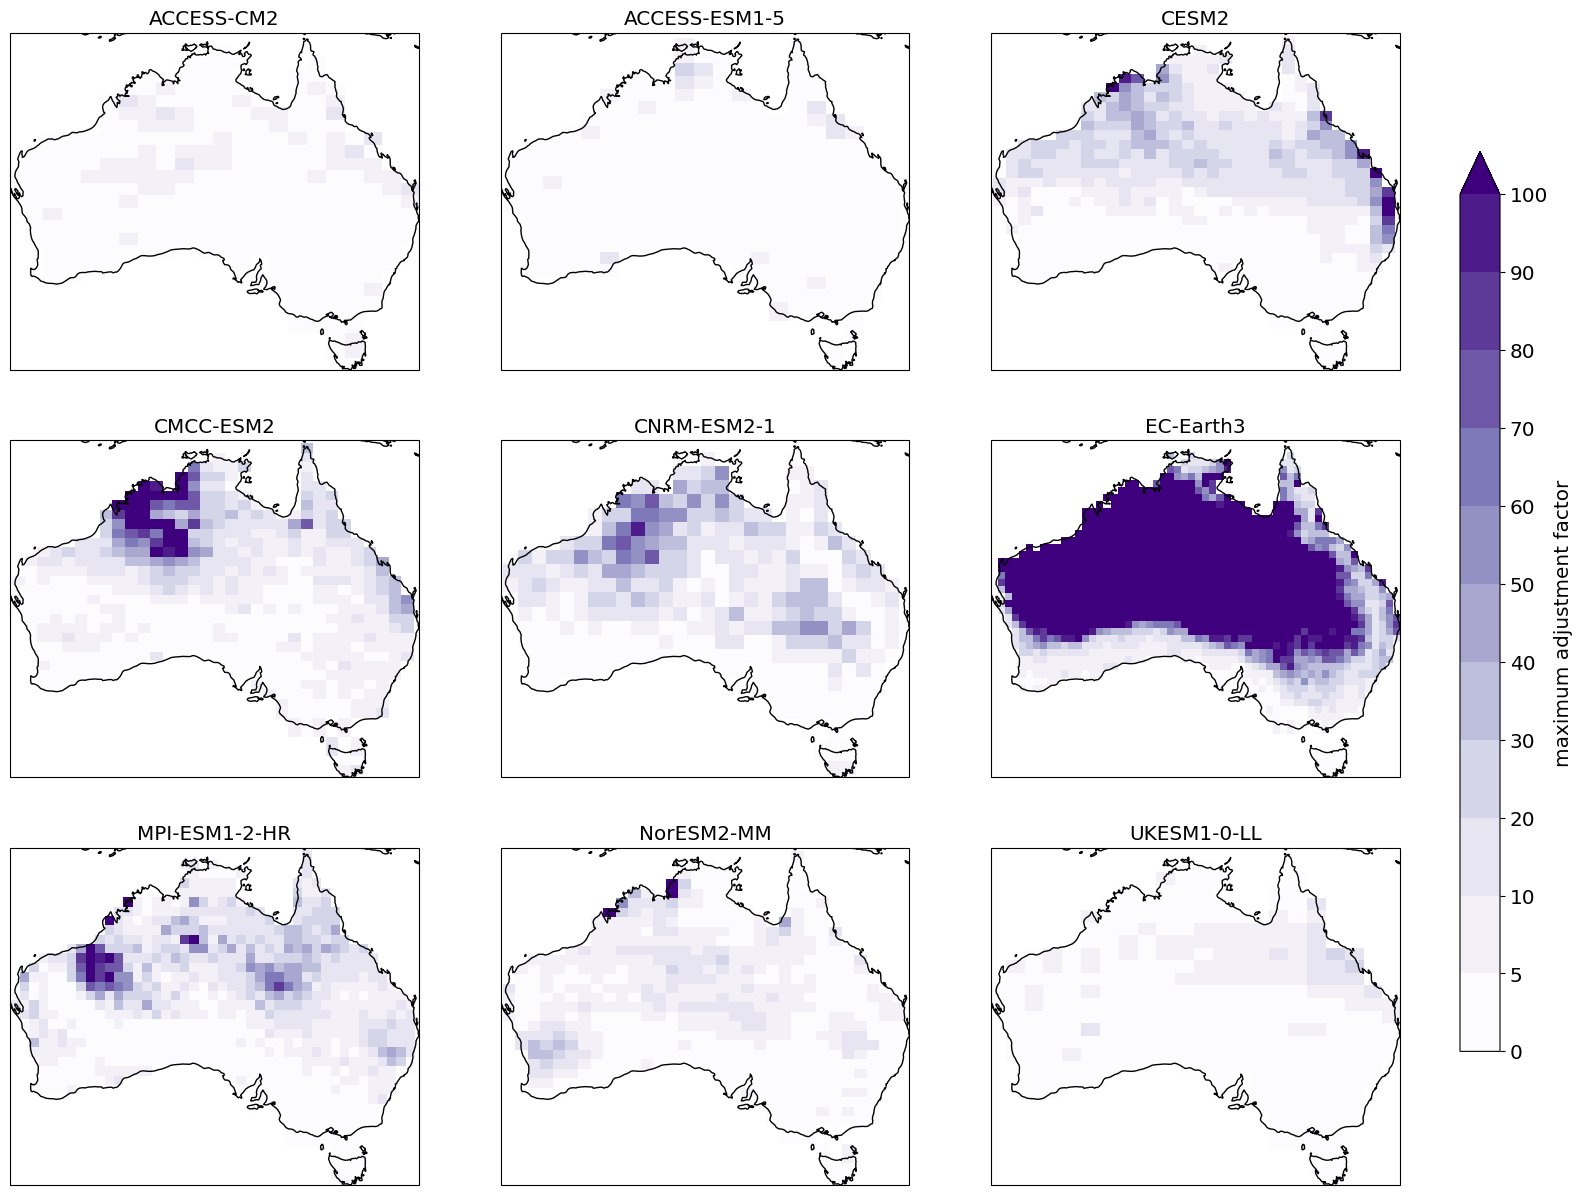

In [9]:
levels = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

fig = plt.figure(figsize=[20, 15])
for plotnum, model in enumerate(model_list): 
    ax = fig.add_subplot(3, 3, plotnum + 1, projection=ccrs.PlateCarree(central_longitude=180))
    im = max_af_dict[model].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='Purples',
        levels=levels,
        extend='max',
        add_colorbar=False,
    )
    ax.coastlines()
    ax.set_title(model, size='x-large')
    ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize='x-large')
cbar.set_ticks(ticks=levels, labels=levels)
cbar.set_label('maximum adjustment factor', size='x-large')

plt.savefig(
    'max_pr_adjustment.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()

## Mean match adjustment

In [10]:
mc_files = sorted(glob.glob("/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/*/ssp370/*/day/pr/2070-2099/pr-adjustment-factors*.nc"))
mc_files

['/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/ACCESS-CM2/ssp370/r4i1p1f1/day/pr/2070-2099/pr-adjustment-factors_day_ACCESS-CM2_ssp370_r4i1p1f1_AUS-11_2070-2099_qdc-multiplicative-monthly-q100-linear-maxaf5-annual-change-matched_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc',
 '/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/ACCESS-ESM1-5/ssp370/r6i1p1f1/day/pr/2070-2099/pr-adjustment-factors_day_ACCESS-ESM1-5_ssp370_r6i1p1f1_AUS-11_2070-2099_qdc-multiplicative-monthly-q100-linear-maxaf5-annual-change-matched_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc',
 '/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6-v2/BARRA-R2/CESM2/ssp370/r11i1p1f1/day/pr/2070-2099/pr-adjustment-factors_day_CESM2_ssp370_r11i1p1f1_AUS-11_2070-2099_qdc-multiplicative-monthly-q100-linear-maxaf5-annual-change-matched_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc',
 '/g/data/ia39/australian-climate-service/test-data/QDC-CMIP

In [14]:
mc_dict = {}
for mc_file in mc_files:
    model = mc_file.split('/')[8]
    ds = xr.open_dataset(mc_file)
    try:
        ds = ds.drop_vars('crs')
    except ValueError:
        pass
    mc = subset_shape(ds['pr'], shape=shape)
    mc_dict[model] = mc.compute()

In [15]:
model_list = list(mc_dict.keys())

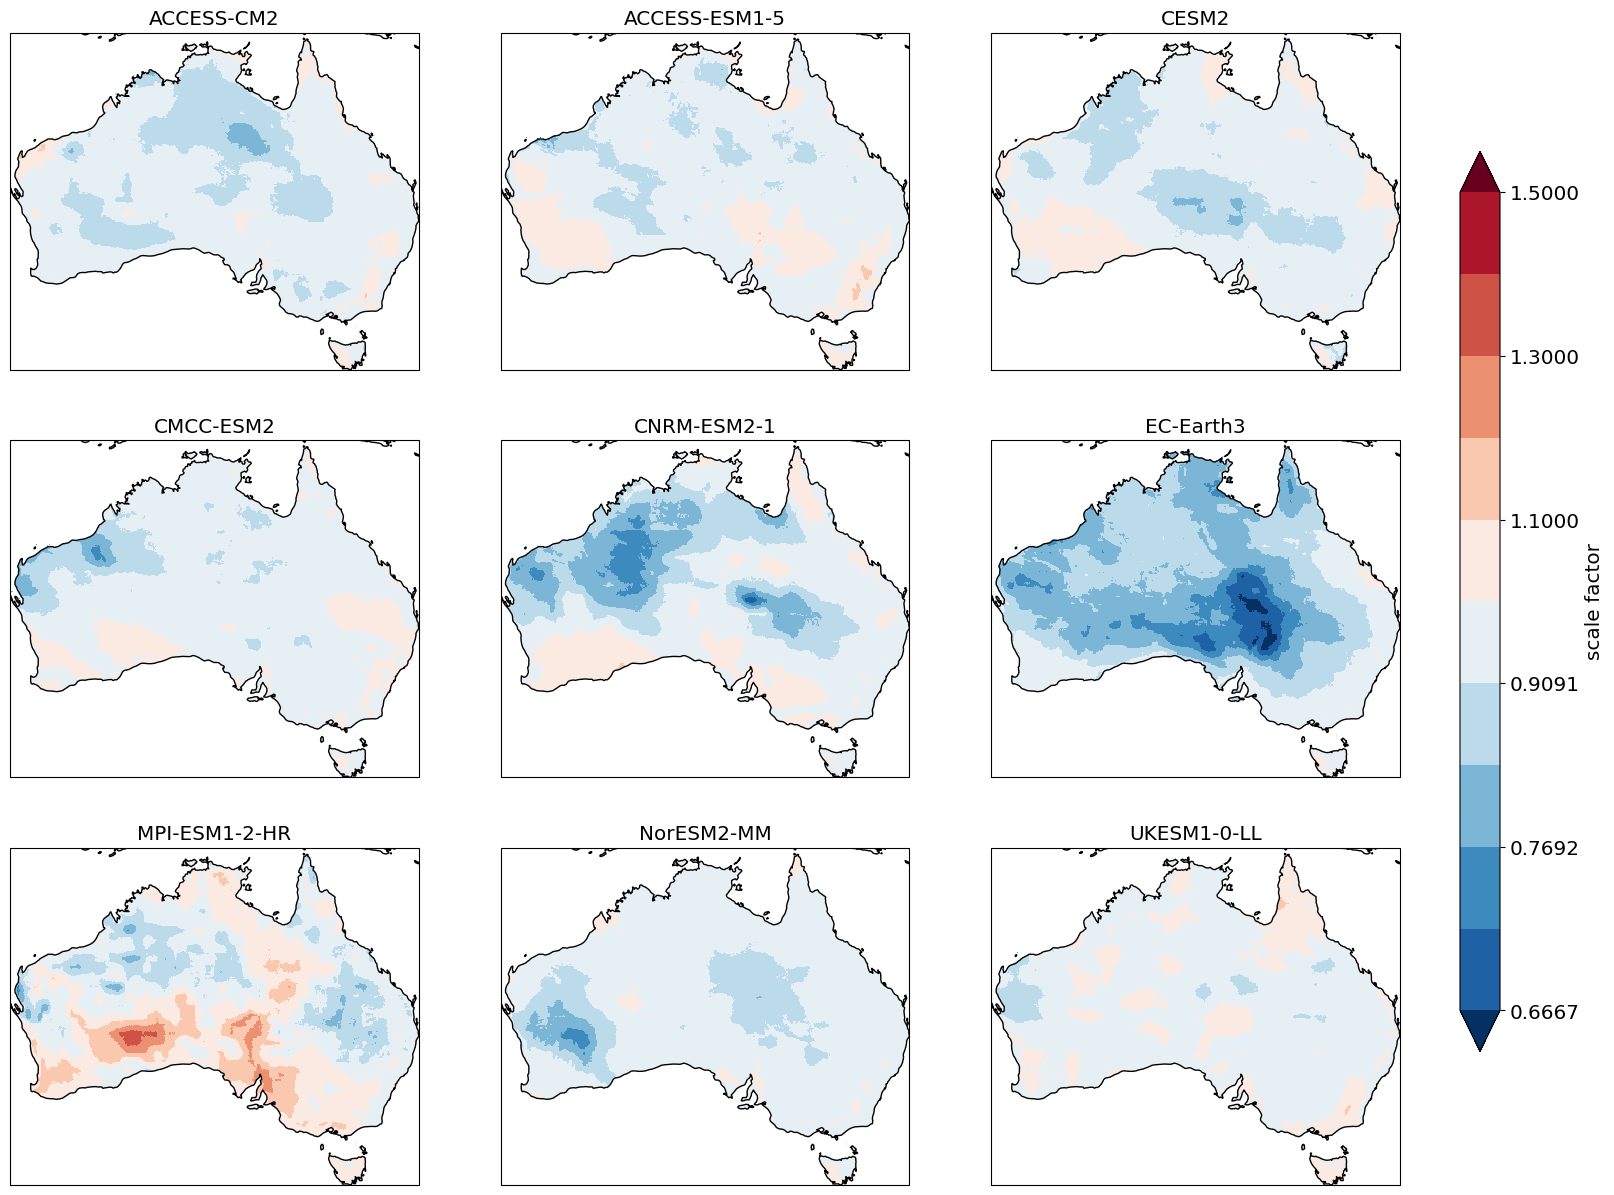

In [19]:
levels = [1/1.5, 1/1.4, 1/1.3, 1/1.2, 1/1.1, 1, 1.1, 1.2, 1.3, 1.4, 1.5]

fig = plt.figure(figsize=[20, 15])
for plotnum, model in enumerate(model_list): 
    ax = fig.add_subplot(3, 3, plotnum + 1, projection=ccrs.PlateCarree(central_longitude=180))
    im = mc_dict[model].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        levels=levels,
        extend='both',
        add_colorbar=False,
    )
    ax.coastlines()
    ax.set_title(model, size='x-large')
    ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize='x-large')
#cbar.set_ticks(ticks=levels, labels=levels)
cbar.set_label('scale factor', size='x-large')

plt.savefig(
    'trend_match_scale_factors_BARRA-R2.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()

## Scrap code related to dry bias

I explored only plotting where the model has a dry bias, but that didn't change the result much.

In [44]:
barra_files = sorted(glob.glob("/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/pr/v20240809/pr_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_*.nc"))

In [53]:
ds_barra = utils.read_data(
    barra_files,
    'pr',
    time_bounds=['1985', '2014'],
    input_units="kg m-2 s-1",
    output_units="mm day-1",
    lat_bounds=[ymin, ymax],
    lon_bounds=[xmin, xmax],
)
try:
    ds_barra = ds_barra.drop_vars('crs')
except ValueError:
    pass

In [55]:
ds = xr.open_dataset(af_files[0])
quantiles = ds['quantiles'].data

In [56]:
barra_quantiles = utils.get_quantiles(ds_barra['pr'], quantiles, timescale='monthly')